# Building an NLP Pipeline



In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# load file into dataframe
csv_dir = '/content/drive/My Drive/Colab Notebooks/CS420/NLPCodes'

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
import sys
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.parse.malt import MaltParser
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

import pandas as pd
import numpy as np

df = []
with open(f'{csv_dir}/200Reviews.csv', 'r') as file:
  df = pd.read_csv(file)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Unnamed: 0,id,sentiment,review
0,0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [ ]:
#Step1: Sentence segmentation
df['review'] = df['review'].apply(lambda sentences: nltk.sent_tokenize(sentences))
df.iloc[0].review[0]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again.'

In [ ]:
#Step 2: Word tokenization
df['review'] = df['review'].apply(lambda sentences: [nltk.word_tokenize(sentence) for sentence in sentences])
# df.iloc[0].review[0]

In [ ]:
#Step 3: Predicting parts off speech for each token
df['review'] = df['review'].apply(lambda sentences: [nltk.pos_tag(sentence) for sentence in sentences])
# df.iloc[0].review[0]

In [ ]:
#Step 4: Text Lemmatization
# Get Wordnet Tag
def get_wordnet_pos(treebank_tag):
  if treebank_tag.startswith('J'):
    return wordnet.ADJ
  elif treebank_tag.startswith('V'):
    return wordnet.VERB
  elif treebank_tag.startswith('N'):
    return wordnet.NOUN
  elif treebank_tag.startswith('R'):
    return wordnet.ADV
  else:
    return ''
# Get Lemmatized word
def getLemmatizedWord(word, wordnettag):
  wordnet_lemmatizer = WordNetLemmatizer()
  lemmatizedword = ''
  if wordnettag == '':
      lemmatizedword = wordnet_lemmatizer.lemmatize(word.lower())
  else:
      lemmatizedword = wordnet_lemmatizer.lemmatize(word.lower(),pos=wordnettag)
  if word.istitle():
      lemmatizedword = lemmatizedword.capitalize()
  elif word.upper()==word:
      lemmatizedword = lemmatizedword.upper()
  else:
      lemmatizedword = lemmatizedword
  return lemmatizedword

df['review'] = df['review'].apply(lambda sentences: [[getLemmatizedWord(word[0], get_wordnet_pos(word[1])) for word in sentence] for sentence in sentences])
# df.iloc[0].review[0]

In [ ]:
#Step 5: Identifying stop words
stopWords = set(stopwords.words('english'))
df['review'] = df['review'].apply(lambda sentences: [[word for word in sentence if word not in stopWords] for sentence in sentences])
# df.iloc[0].review[0]

# Co-occurence Matrix

In [ ]:
class CoOccurenceMatrix:
  def __init__(self, window):
    self.vocabulary = []
    self.matrix = []
    self.window = window
    self.embedding = []
    self.u = None
    self.s = None
    self.vh = None
  
  def add(self, word, window):
    self.newWord(word) # add word
    index = self.vocabulary.index(word)
    # add all words in window
    for coword in window:
      self.newWord(coword) # add coword
      self.matrix[index][self.vocabulary.index(coword)] += 1
      
  def newWord(self, word):
    # add word to matrix and vocabulary if not in vocabulary
    if word not in self.vocabulary:
      self.vocabulary.append(word)
      for line in self.matrix:
        line.append(0)
      self.matrix.append([0 for i in range(len(self.vocabulary))])

  def addSentence(self, sentence):
    # for each word create window, and add word
    for count, word in enumerate(sentence):
      window = sentence[max(0, count - self.window) : min(len(self.vocabulary), count + self.window + 1)]
      if word in window:
        window.remove(word)
      self.add(word, window)

  def createEmbedding(self, size=100):
    self.u, self.s, self.vh = np.linalg.svd(matrix.matrix, full_matrices=False)
    for word in self.u:
      self.embedding.append(word[:size])
  
  def printMatrix(self, maxSizePrint=10):
    print(f'matrix width: {len(self.matrix[0])}')
    print(f'matrix height: {len(self.matrix)}')
    print(f'vocab size: {len(self.vocabulary)}')
    print(f'vocab list: {self.vocabulary[:maxSizePrint]}')
    for i in range(min(maxSizePrint, len(self.vocabulary))):
      print(self.matrix[i][:min(maxSizePrint, len(self.vocabulary))])
  
  def printEmbedding(self, maxSizePrint=10):
    print(f'embedding width: {len(self.embedding[0])}')
    print(f'embedding height: {len(self.embedding)}')
    for i in range(min(maxSizePrint, len(self.vocabulary))):
      print(self.embedding[i][:min(maxSizePrint, len(self.embedding[0]))])
    


In [ ]:
#create co-occurence matrix
matrix = CoOccurenceMatrix(5)
for index, row in df.iterrows():
  for sentence in row.review:
    matrix.addSentence(sentence)

In [ ]:
matrix.printMatrix()

matrix width: 7417
matrix height: 7417
vocab size: 7417
vocab list: ['``', 'With', 'stuff', 'go', 'moment', 'MJ', "'ve", 'start', 'listen', 'music']
[0, 0, 0, 3, 0, 0, 4, 3, 0, 1]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 0, 1, 0, 0, 1, 0, 0, 1]
[4, 1, 2, 0, 0, 1, 1, 1, 1, 0]
[1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 2, 1, 0, 0, 0, 0, 0]
[4, 1, 2, 2, 1, 1, 0, 0, 0, 2]
[3, 0, 1, 2, 1, 1, 1, 2, 0, 0]
[0, 0, 0, 2, 1, 1, 1, 1, 0, 0]
[1, 0, 1, 0, 1, 1, 3, 1, 1, 2]


In [ ]:
# get first 100 column of each matrix
matrix.createEmbedding()

In [ ]:
matrix.printEmbedding(4)

embedding width: 100
embedding height: 7417
[-0.00319844 -0.03302494  0.0024539   0.0214006 ]
[-0.00056103 -0.00072078 -0.00038473  0.00099664]
[-1.39089096e-04 -2.77688367e-03  3.47213244e-05  1.42663313e-03]
[-4.07631138e-03 -3.56803406e-02  9.96355636e-05  2.17062358e-02]


# Word2Vec

In [ ]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
import math

# Get the interactive Tools for Matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
sentences = []
for index, row in df.iterrows():
  for sentence in row.review:
    sentences.append(sentence)

In [ ]:
# Creating the model and setting values for the various parameters
num_features = 100  # Word vector dimensionality
min_word_count = 10 # Minimum word count
num_workers = 4     # Number of parallel threads
context = 5         # Context window size
downsampling = 1e-3 # (0.001) Downsample setting for frequent words

model = Word2Vec(sentences,
                 size=num_features,
                 window=context,
                 min_count=min_word_count,
                 workers=num_workers,
                 sample=downsampling)

# Plot

In [ ]:
print(len(model.wv.index2word))
print(model.wv.index2word)
# print(sentences)

475
[',', '.', "''", '/', '<', 'br', '>', 'I', "'s", 'film', 'movie', 'The', '\\', ')', '(', '!', "n't", 'one', '``', 'make', '?', 'like', 'good', 'get', 'It', 'see', 'bad', 'This', 'go', '...', 'character', 'watch', ':', 'would', 'time', 'really', 'even', 'story', 'people', '-', 'well', 'first', 'look', 'scene', 'much', 'thing', 'come', 'way', 'could', "'", 'end', 'think', 'say', 'know', 'take', 'try', 'give', 'great', 'A', 'actor', '&', 'show', 'also', 'play', 'find', 'seem', 'There', 'But', 'love', 'life', 'start', 'year', 'part', 'work', 'never', 'And', 'two', 'many', '--', 'director', "'re", 'little', 'zombie', 'turn', 'ever', 'still', 'If', 'best', ';', 'plot', 'want', 'without', "'m", 'minute', 'He', 'guy', 'fact', 'In', 'horror', 'though', 'performance', 'cast', 'back', 'kill', 'star', 'point', 'interesting', "'ve", 'need', 'pretty', 'acting', 'funny', 'whole', 'line', 'put', 'use', 'nothing', 'old', 'You', 'big', 'lot', 'name', 'rather', 'actually', 'last', 'man', 'video', 'fa

['actor', 'show', 'director', 'film', 'movie', 'fun', 'woman', 'friend', 'girl', 'book']
['actor', 'show', 'director', 'film', 'movie', 'fun', 'woman', 'friend', 'girl', 'book']


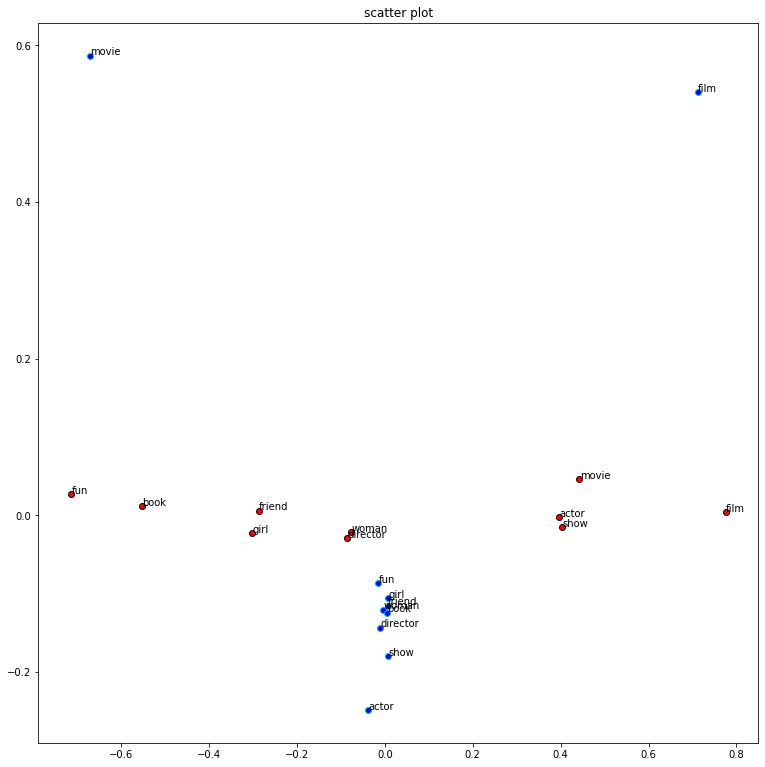

In [ ]:
# get random words in word2vec model
w2v_words = ['actor', 'show', 'director', 'film', 'movie', 'fun', 'woman', 'friend', 'girl', 'book']
# for i in np.random.rand(5):
#   i = math.floor(i * len(model.wv.index2word))
#   w2v_words.append(model.wv.index2word[i])

svd_words = [word for word in w2v_words if word in matrix.vocabulary]

print(w2v_words)
print(svd_words)

# get word vectors
w2v_word_vectors = np.array([model.wv[w] for w in w2v_words])
svd_word_vectors = [matrix.embedding[matrix.vocabulary.index(word)] for word in svd_words]
# tranform to 2d
w2v_twodim = PCA().fit_transform(w2v_word_vectors)[:,:2]
svd_twodim = PCA().fit_transform(svd_word_vectors)[:,:2]

# plt on graph
fig=plt.figure(figsize=(10,10))
ax=fig.add_axes([0,0,1,1])
ax.set_title('scatter plot')
# w2v
ax.scatter(w2v_twodim[:,0], w2v_twodim[:,1], edgecolors='k', c='r')
for word, (x,y) in zip(w2v_words, w2v_twodim):
  ax.text(x+0.001, y+0.001, word)
# svd
ax.scatter(svd_twodim[:,0], svd_twodim[:,1], edgecolors='c', c='b')
for word, (x,y) in zip(svd_words, svd_twodim):
  ax.text(x+0.001, y+0.001, word)
plt.show()


In [ ]:
# Create data
N = 500
x = np.random.rand(N)
y = np.random.rand(N)
colors = (0,0,0)
area = np.pi*3

# Plot
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
vector = model.wv['people']  # get numpy vector of a word
vector